In [1]:
import pandas as pd
import pickle
from codecs import getdecoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import regex
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from string import punctuation
from gensim.models.phrases import Phrases, Phraser
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.extmath import randomized_svd
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy
import seaborn as sns
from gensim import corpora, models, similarities, matutils, models
import pyLDAvis.gensim
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.mixture import GaussianMixture

%matplotlib inline

In [2]:
nlp = spacy.load('en')

In [3]:
with open("paragraph_df.pkl", 'rb') as picklefile: 
    df2 = pickle.load(picklefile)

In [4]:
df2.head()

,date,location,paragraph,title
1,"January 17, 2017",James S. Brady Press Briefing Room,James S. Brady Press Briefing Room,Press Briefing by Press Secretary Josh Earnest...
2,"January 17, 2017",James S. Brady Press Briefing Room,12:15 P.M. EST,Press Briefing by Press Secretary Josh Earnest...
3,"January 17, 2017",James S. Brady Press Briefing Room,"MR. EARNEST: Good afternoon, everybody. I do...",Press Briefing by Press Secretary Josh Earnest...
4,"January 17, 2017",James S. Brady Press Briefing Room,Q Thank you. (Laughter.),Press Briefing by Press Secretary Josh Earnest...
5,"January 17, 2017",James S. Brady Press Briefing Room,MR. EARNEST: But because today marks my last ...,Press Briefing by Press Secretary Josh Earnest...


In [5]:
df2.tail()

,date,location,paragraph,title
123462,"January 28, 2009",None,\n Press Briefing by Press Secretary Robert Gi...,Press Briefing 1/28/09
123463,"January 27, 2009",None,\n Press Briefing by Press Secretary Robert Gi...,Press Briefing 1/27/09
123464,"January 26, 2009",None,\n Press Briefing by Press Secretary Robert G...,Press Briefing 1/26/09
123465,"January 23, 2009",None,\n Press Briefing by Press Secretary Robert G...,Press Briefing 1/23/09
123466,"January 22, 2009",None,\n Press Briefing by Press Secretary Robert Gi...,Press Briefing 1/22/09


In [6]:
def flat_splitter(df):
    """
    Splits documents (initially one per row) into one paragraph per row.
    """
    for document in df:
        for paragraph in document['paragraph'].split('\n'):
            yield {'date': document['date'], 'title': document['title'], 'location': document['location'], \
                   'paragraph': paragraph}

In [7]:
okdata = df2.groupby("date").filter(lambda x: len(x) > 1)

In [8]:
# some documents didn't split properly into paragraphs so fixing here...
brokendata = df2.groupby("date").filter(lambda x: len(x) == 1)
records = brokendata.to_dict(orient = 'records')

record_dict = flat_splitter(records)
fixeddata = pd.DataFrame(record_dict)

In [9]:
okdata.shape

(120380, 4)

In [10]:
fixeddata.shape

(106084, 4)

In [11]:
df2 = pd.concat([okdata, fixeddata], axis = 0)
df2.shape

(226464, 4)

In [12]:
df2['dt'] = pd.to_datetime(df2.date)

In [13]:
# take second four years
df2 = df2[df2.dt >= 'January 21, 2013']

In [14]:
df2['paragraph'] = df2.paragraph.str.replace('\xa0', '')
df2['paragraph'] = df2.paragraph.str.replace('\n', ' ')

# remove this as scraping wasn't clean on separating location out from body
df2['paragraph'] = df2.paragraph.str.replace('James S. Brady Press Briefing Room', '')

# get rid of times
df2['paragraph'] = df2.paragraph.str.replace(r'[0-9]+\:[0-9]+[ ]*[A,a,P,p][.]*[m, M][.]*[ ]*[A-Z]{2}[T]', '')

# get rid of empty cells
df2 = df2[df2.paragraph != '']
df2 = df2[df2.paragraph != ' ']

# convert all other numbers to a standard number (ex. 99)
# note this removes the word attached to the number (if it exists); possibly find a way later to leave in years
df2['paragraph'] = df2.paragraph.str.replace(r'[0-9]+', '99')

# removing common punctuation (leave in periods and commas)
df2['paragraph'] = df2.paragraph.str.replace(r'[:;\'!?\-@$%#*&+=\"\“’()]', '')

In [15]:
df2.head()

,date,location,paragraph,title,dt
3,"January 17, 2017",James S. Brady Press Briefing Room,"MR. EARNEST Good afternoon, everybody. I dont ...",Press Briefing by Press Secretary Josh Earnest...,2017-01-17
4,"January 17, 2017",James S. Brady Press Briefing Room,Q Thank you. Laughter.,Press Briefing by Press Secretary Josh Earnest...,2017-01-17
5,"January 17, 2017",James S. Brady Press Briefing Room,MR. EARNEST But because today marks my last br...,Press Briefing by Press Secretary Josh Earnest...,2017-01-17
6,"January 17, 2017",James S. Brady Press Briefing Room,As I prepared to stand here at this podium for...,Press Briefing by Press Secretary Josh Earnest...,2017-01-17
7,"January 17, 2017",James S. Brady Press Briefing Room,I had been in D.C. for a grand total of two we...,Press Briefing by Press Secretary Josh Earnest...,2017-01-17


In [16]:
# dropping observations where documents didn't break properly by paragraph (i.e. those where there are 3 or less paras)
# this is 223 documents 
# note: fix this later
df2 = df2.groupby("date").filter(lambda x: len(x) > 6)

In [17]:
df2.to_pickle('fixed_df.pkl')

In [18]:
doc_list = df2.paragraph.tolist()

In [19]:
len(doc_list)

121562

In [20]:
#doc_list[:10]

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121562 entries, 3 to 78174
Data columns (total 5 columns):
date         121562 non-null object
location     109549 non-null object
paragraph    121562 non-null object
title        121562 non-null object
dt           121562 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 5.6+ MB


## entity extraction and stemming

In [22]:
def underscore_entities(documents):
    
    docs = []
    for i in documents:
        docs.append(nlp(i))
    
    uds_entities = []

    for para in docs:

        ent_chars = []
        for i in para.ents:
            ent_chars.append((i.start_char, i.end_char))
        #print(para.ents)
        #print(ent_chars)
        
        new_string = []
        for index, item in enumerate(list(str(para))):
            for i, j in enumerate(ent_chars):
                if j[0] < index < j[1] and item == ' ':
                    item = '_'
            new_string.append(item)

        ns = ''.join(new_string)
        uds_entities.append(ns)
        
    return uds_entities

In [23]:
def underscore_nouns(documents):
    
    docs = []
    for i in documents:
        docs.append(nlp(i))
        
    noun_entities = []

    for para in docs:

        ent_chars = []
        for i in para.noun_chunks:
            ent_chars.append((i.start_char, i.end_char))
        #print(para.noun_chunks)
        #print(ent_chars)

        new_string = []
        for index, item in enumerate(list(str(para))):
            for i, j in enumerate(ent_chars):
                if j[0] < index < j[1] and item == ' ':
                    item = '_'
            new_string.append(item)

        ns = ''.join(new_string)
        noun_entities.append(ns)
        
    return noun_entities

# note: may need to remove laughter and applause as these are getting added in

In [24]:
def entities_and_nouns(documents):
    
    docs = []
    for i in documents:
        docs.append(nlp(i))
    
    entities = []

    for para in docs:

        ent_chars_one = []
        for i in para.ents:
            ent_chars_one.append((i.start_char, i.end_char))
            
        ent_chars_two = []
        for i in para.noun_chunks:
            ent_chars_two.append((i.start_char, i.end_char))
        
        ent_chars = ent_chars_one + ent_chars_two
        #print(ent_chars_two)

        new_string = []
        for index, item in enumerate(list(str(para))):
            for i, j in enumerate(ent_chars):
                if j[0] < index < j[1] and item == ' ':
                    item = '_'
            new_string.append(item)

        ns = ''.join(new_string)
        entities.append(ns)
        
    return entities

In [25]:
def porter_stem(doc):
    stems = []
    for line in doc:
        doc_stems = []
        tokens = word_tokenize(line)
        for item in tokens:
            doc_stems.append(PorterStemmer().stem(item))
        stems.append(' '.join(doc_stems))
    return stems

In [26]:
def lancaster_stem(doc):
    stems = []
    for line in doc:
        doc_stems = []
        tokens = word_tokenize(line)
        for item in tokens:
            doc_stems.append(LancasterStemmer().stem(item))
        stems.append(' '.join(doc_stems))
    return stems

In [27]:
def svd_km_plot(vecs):

    U, Sigma, VT = randomized_svd(vecs, n_components = 300, n_iter = 5)

    km = KMeans(n_clusters = 15, random_state = 42)
    km.fit(np.dot(U, np.diag(Sigma)))

    # predict one cluster per document
    predicted_cluster = km.predict(np.dot(U, np.diag(Sigma)))

    df = pd.DataFrame(U[:,0:2], columns = ['first_feat', 'second_feat'])
    df['cluster'] = predicted_cluster

    sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster', data = df, fit_reg = False)

### create test sets

In [28]:
test = doc_list[:1000]

In [29]:
ent_test = underscore_entities(test)

In [30]:
nouns_test = underscore_nouns(test)

In [31]:
e_and_n_test = entities_and_nouns(test)

### compare stemmers

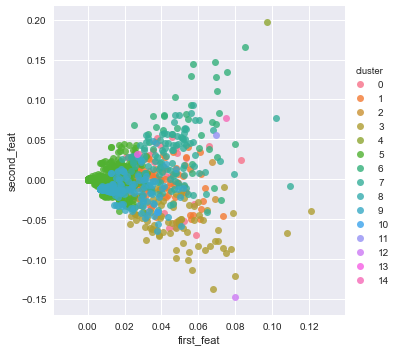

In [32]:
cv = CountVectorizer(stop_words = 'english')
vecs = cv.fit_transform(porter_stem(ent_test))
svd_km_plot(vecs)

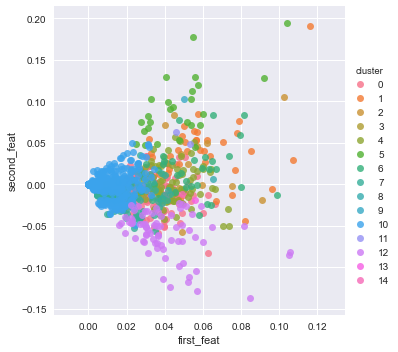

In [33]:
cv = CountVectorizer(stop_words = 'english')
vecs = cv.fit_transform(lancaster_stem(ent_test))
svd_km_plot(vecs)

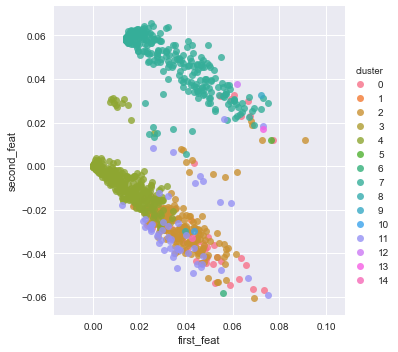

In [34]:
binary = CountVectorizer(stop_words = 'english', binary = True)
vecs = binary.fit_transform(porter_stem(ent_test))
svd_km_plot(vecs)

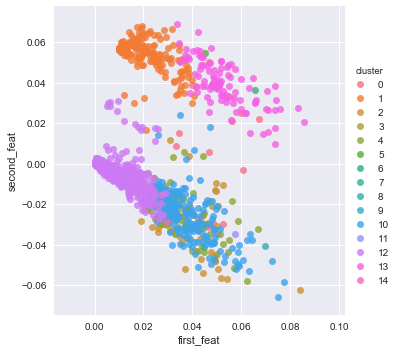

In [35]:
binary = CountVectorizer(stop_words = 'english', binary = True)
vecs = binary.fit_transform(lancaster_stem(ent_test))
svd_km_plot(vecs)

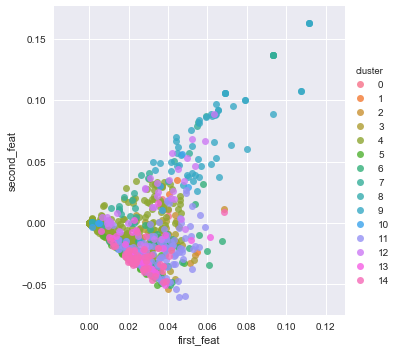

In [36]:
tfidf = TfidfVectorizer(stop_words = "english")
vecs = tfidf.fit_transform(porter_stem(ent_test))
svd_km_plot(vecs)

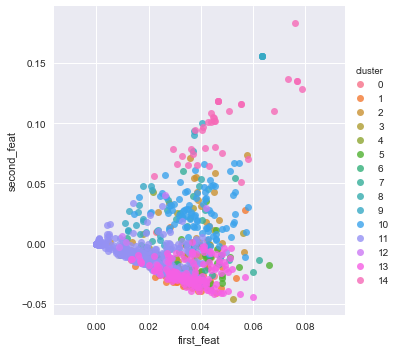

In [37]:
tfidf = TfidfVectorizer(stop_words = "english")
vecs = tfidf.fit_transform(lancaster_stem(ent_test))
svd_km_plot(vecs)

**will go with lancaster stemmer**

### compare entity extraction and vectorizers

In [38]:
test_list = [ent_test, nouns_test, e_and_n_test]

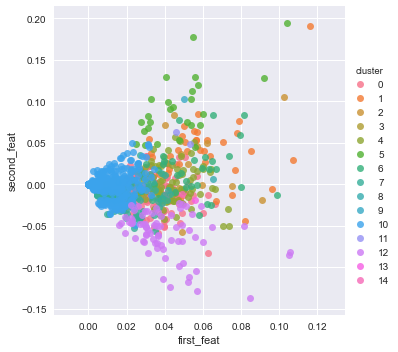

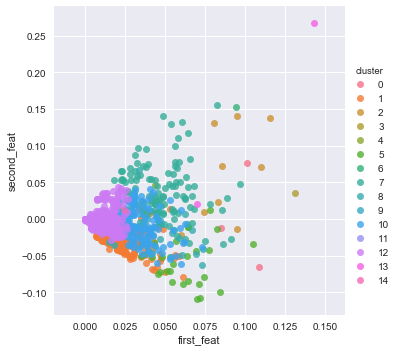

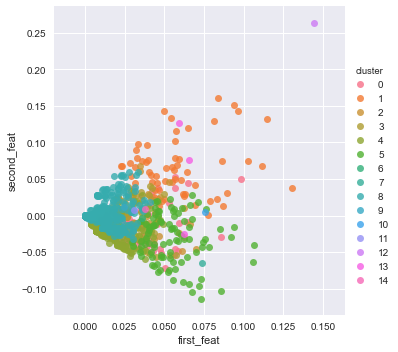

In [39]:
for i in test_list:
    cv = CountVectorizer(stop_words = 'english')
    vecs = cv.fit_transform(lancaster_stem(i))
    svd_km_plot(vecs)

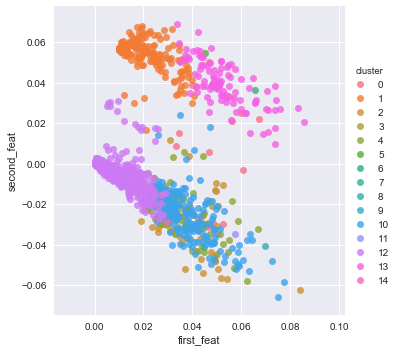

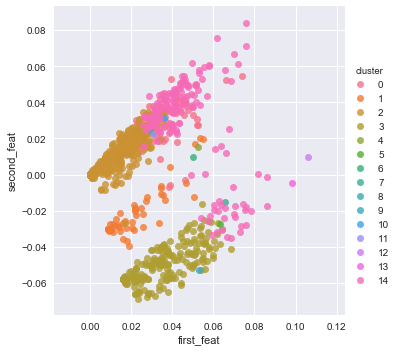

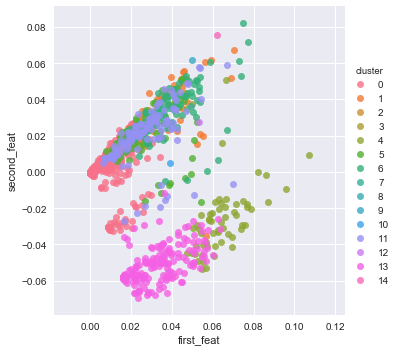

In [40]:
for i in test_list:
    binary = CountVectorizer(stop_words = 'english', binary = True)
    vecs = binary.fit_transform(lancaster_stem(i))
    svd_km_plot(vecs)

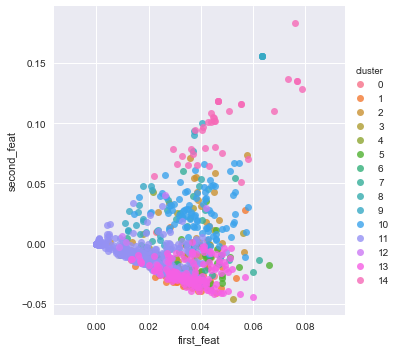

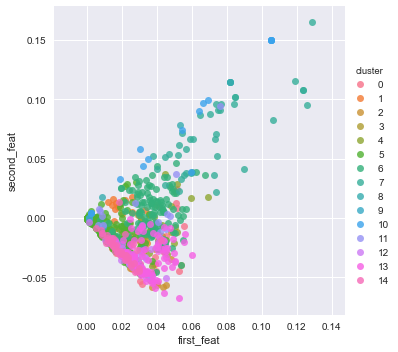

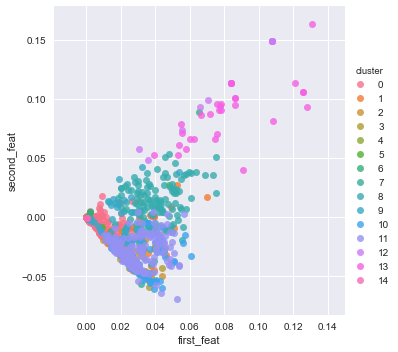

In [41]:
for i in test_list:
    tfidf = TfidfVectorizer(stop_words = "english")
    vecs = tfidf.fit_transform(lancaster_stem(i))
    svd_km_plot(vecs)

## set test size

In [42]:
# currently at 5000

In [43]:
test = doc_list[:5000]

In [44]:
# then pick one vector section to run

## count vecs

this does poorly (gives common words in many clusters)

In [45]:
# stemmed_ents = lancaster_stem(underscore_entities(test))

In [46]:
# cv = CountVectorizer(stop_words = 'english')
# vecs = cv.fit_transform(stemmed_ents)

In [47]:
# cv_df = pd.DataFrame(vecs.todense(), columns=cv.get_feature_names())
# cv_df.shape

In [48]:
# terms = cv.get_feature_names()

In [49]:
# terms

## binary vecs

In [50]:
# entities_and_nouns gives 19645 features...
# stemmed_ents = lancaster_stem(entities_and_nouns(test))
# stemmed_ents = lancaster_stem(underscore_entities(test))

In [51]:
# binary = CountVectorizer(stop_words = 'english', binary = True)
# vecs = binary.fit_transform(stemmed_ents)

In [52]:
# binary_df = pd.DataFrame(vecs.todense(), columns=binary.get_feature_names())
# binary_df.shape

In [53]:
# terms = binary.get_feature_names()

In [54]:
# terms

##  tfidf vecs

tfidf and lancaster seem to be the best

In [55]:
# note test is currently at 5000
stemmed_ents = lancaster_stem(underscore_entities(test))
# full data
# stemmed_ents = lancaster_stem(underscore_entities(doc_list))

In [56]:
tfidf = TfidfVectorizer(stop_words = "english")
vecs = tfidf.fit_transform(stemmed_ents)

In [57]:
tfidf_df = pd.DataFrame(vecs.todense(), columns=tfidf.get_feature_names())
tfidf_df.shape

(5000, 6295)

In [58]:
terms = tfidf.get_feature_names()

In [59]:
terms

['99',
 '9999',
 '9999_a',
 '9999_p',
 '99_99_million',
 '99__and',
 '99__fiscal_year_99',
 '99__im',
 '99__its',
 '99_a_year',
 '99_an_hour',
 '99_and_99',
 '99_billion',
 '99_days',
 '99_hours',
 '99_hours_ago',
 '99_in',
 '99_in_the_dow',
 '99_jobs',
 '99_million',
 '99_million_barrels',
 '99_minutes',
 '99_minutes_interview',
 '99_months',
 '99_or',
 '99_or_99',
 '99_or_99_years_ago',
 '99_or_so',
 '99_perc',
 '99_percent',
 '99_proisil',
 '99_special_operations_forces',
 '99_square_kilometers',
 '99_straight_months',
 '99_subpar_years',
 '99_to',
 '99_to_99',
 '99_trillion',
 '99_trillion_reduction',
 '99_world_series_victory',
 '99_years',
 '99_years_ago',
 '99_years_ago_this_week',
 '99_years_ago_today',
 '99_years_later',
 '99_years_or_so',
 '99character',
 '99day',
 '99foot',
 '99kilometer',
 '99month',
 '99nd',
 '99page',
 '99plus_million',
 '99pound',
 '99s',
 '99some_odd_years_or_so_ago',
 '99st',
 '99st_century',
 '99th',
 '_99',
 '_brady_briefing_room',
 '_bush',
 '_but',

In [60]:
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

## LSA (sklearn) + kmeans / dbscan / agglomerative clustering / spectral / gaussian mixture

**SVD + normalize**

In [61]:
lsa = TruncatedSVD(300, algorithm = 'arpack')
lsa_vecs = lsa.fit_transform(vecs)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)

In [62]:
# note: this doesn't deal with clusters, just gets the words from lsa...
# component three looks like the economy...

lsa_df = pd.DataFrame(lsa.components_.round(5),columns = tfidf.get_feature_names())

for i in range(20):
    print('Component number: ' + str(i))
    print(lsa_df.iloc[i,:].sort_values(ascending = False)[:15])
    print("")

Component number: 0
presid     0.24404
mr         0.24257
hav        0.23463
earnest    0.22939
thi        0.22508
ar         0.18315
ther       0.16518
think      0.15274
wel        0.13468
wil        0.13127
som        0.11859
wer        0.10836
going      0.10735
al         0.10073
just       0.09668
Name: 0, dtype: float64

Component number: 1
earnest      0.63711
mr           0.60990
okay         0.12456
wel          0.08831
ye           0.08512
laught       0.07674
thank        0.06281
dont         0.05317
yeah         0.04490
im           0.04001
sur          0.03312
schultz      0.02672
let          0.02477
apprecy      0.02331
everybody    0.02135
Name: 1, dtype: float64

Component number: 2
thank        0.84432
josh         0.29958
everybody    0.16425
tomorrow     0.12763
yo           0.11803
quest        0.08403
want         0.07890
laught       0.07879
al           0.07412
kevin        0.07172
presid       0.05776
apprecy      0.05359
press        0.04781
start        0.04

**kmeans**

In [63]:
cluster_num = 40
km = KMeans(n_clusters = cluster_num, random_state = 42)
km.fit(lsa_vecs)

# predict one cluster per document
predicted_cluster = km.predict(lsa_vecs)

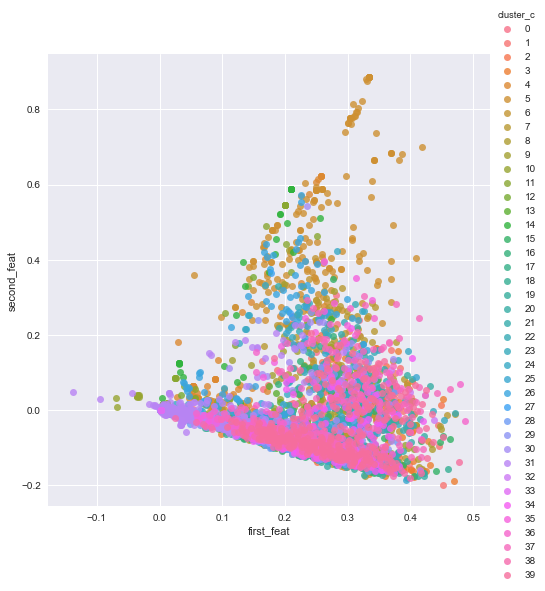

In [64]:
df = pd.DataFrame(lsa_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 7)

In [65]:
#lsa.explained_variance_ratio_

In [66]:
# km.cluster_centers_.shape

In [67]:
# original_space_centroids.shape

In [68]:
# order_centroids

In [69]:
original_space_centroids = lsa.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [70]:
for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 new
 thi
 hav
 report
 conf
 ar
 org
 presid
 mr
 admin
 ther
 annount
 dont
 wer
 today
 som
 com
 earnest
 anyth
 seen
 
 
Cluster 1: 
 intellig
 commun
 inform
 assess
 presid
 report
 hav
 thi
 ther
 stat
 elect
 think
 mr
 direct
 publ
 confid
 earnest
 bef
 russ
 som
 
 
Cluster 2: 
 respons
 thi
 ther
 presid
 proport
 hav
 publ
 ar
 som
 congress
 point
 govern
 discuss
 think
 sery
 mr
 wil
 earnest
 wel
 im
 
 
Cluster 3: 
 ar
 ther
 peopl
 thi
 thos
 hav
 som
 wer
 thing
 presid
 mor
 know
 oth
 think
 mak
 wher
 al
 just
 stil
 certain
 
 
Cluster 4: 
 thank
 josh
 everybody
 mr
 tomorrow
 earnest
 wel
 al
 apprecy
 presid
 yo
 thi
 right
 admin
 guy
 hav
 er
 sur
 want
 press
 
 
Cluster 5: 
 mr
 earnest
 wel
 im
 schultz
 sur
 yeah
 ther
 right
 thi
 wil
 dont
 hav
 point
 aw
 rul
 tim
 know
 post
 numb
 
 
Cluster 6: 
 99
 99_percent
 rat
 job
 grow
 sint
 presid
 wag
 unemploy
 econom
 hav
 thi
 ar
 record
 wer
 ov
 wev
 just
 think
 cre
 
 
Cluster 7: 
 ha

**dbscan**

In [71]:
db = DBSCAN(eps = 0.5)
predicted_cluster = db.fit_predict(lsa_vecs)

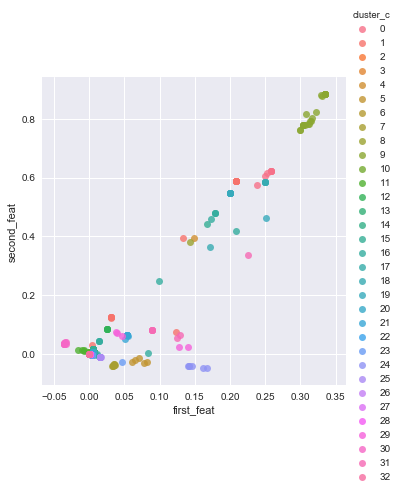

In [72]:
df = pd.DataFrame(lsa_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

# noisy samples are given the label -1 so not plotting
sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df[df.cluster_c != -1], fit_reg = False)

In [73]:
# get cluster centers
n_clusters = 32
clusters = [lsa_vecs[db.labels_ == i] for i in range(n_clusters)]

master = []
for i in range(n_clusters):
    cent = list(np.mean(clusters[i], axis = 0))
    master.append(cent)
cluster_centers = np.reshape(master, (32, 300))

In [74]:
original_space_centroids = lsa.inverse_transform(cluster_centers)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [75]:
for i in range(31):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 thank
 earnest
 mr
 bret
 er
 stop
 apprecy
 sir
 richard
 everybody
 mcgurk
 goy
 jen
 circ
 guy
 behalf
 hi
 yem
 stephany
 schultz_good
 
 
Cluster 1: 
 okay
 earnest
 mr
 barney
 presid
 cr
 mcgurk
 twic
 inquiry
 comfort
 half_an_hour
 late_night
 oh
 holiday
 scheduled
 friday_night
 yesterday
 thought
 regul
 short
 
 
Cluster 2: 
 olivy
 hadnt
 hel
 outcom
 nev
 detect
 dumber
 dumb
 twoandahalfyear
 movy
 chant
 tamp
 let
 quot
 regret
 fun
 dec
 january_99th
 determin
 spent
 
 
Cluster 3: 
 michel
 blood
 unacceiv
 fresh
 exchang
 bound
 stag
 ourselv
 eight_years
 fre
 outsid
 depend
 tri
 goe
 cont
 funct
 repres
 handl
 discount
 washington
 
 
Cluster 4: 
 justin
 earnest
 mr
 mou
 flint
 piec
 money
 pow
 evid
 problem
 best
 pay
 complet
 rhet
 nat
 underpin
 fault
 ourselv
 root
 famili
 
 
Cluster 5: 
 mor
 il
 wer
 going
 im
 presidentelect
 kevin
 concern
 wel
 convers
 jord
 hav
 gre
 shar
 ar
 olivy
 process
 mark
 ther
 admin
 
 
Cluster 6: 
 april


In [76]:
# not doing well...these things shouldn't be clustered

#  the_department_of_stat
#  the_national_security_council
#  lgbt_americans
#  world_series_championship

** hierarchical agglomerative clustering**

In [77]:
cluster_num = 40
hac = AgglomerativeClustering(n_clusters = cluster_num)
# ward is default but worth trying linkage = 'average'
predicted_cluster = hac.fit_predict(lsa_vecs)

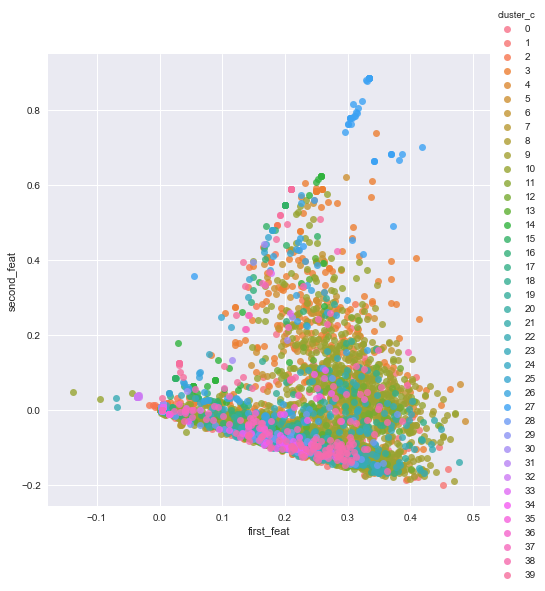

In [78]:
df = pd.DataFrame(lsa_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 7)

In [79]:
# get cluster centers
clusters = [lsa_vecs[hac.labels_ == i] for i in range(cluster_num)]

master = []
for i in range(cluster_num):
    cent = list(np.mean(clusters[i], axis = 0))
    master.append(cent)
cluster_centers = np.reshape(master, (cluster_num, 300))

In [80]:
original_space_centroids = lsa.inverse_transform(cluster_centers)
order_centroids = original_space_centroids.argsort()[:, ::-1]

for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 congress
 sen
 republ
 bil
 nomin
 pass
 presid
 hav
 thi
 memb
 ther
 ar
 wel
 just
 think
 som
 legisl
 tak
 democr
 wil
 
 
Cluster 1: 
 russ
 elect
 act
 hack
 thi
 intellig
 cyb
 malicy
 wer
 think
 hav
 vot
 ther
 polit
 som
 ar
 sery
 presid
 say
 respons
 
 
Cluster 2: 
 welcom
 nic
 sorry
 margaret
 jord
 tolus
 olivy
 chris
 andrew
 jeff
 correct
 robert
 dav
 earnest
 april
 mr
 pleas
 im
 new
 yo
 
 
Cluster 3: 
 mr
 earnest
 wel
 im
 dont
 right
 hav
 know
 thi
 think
 sur
 presid
 schultz
 point
 ther
 aw
 ar
 mayb
 plan
 annount
 
 
Cluster 4: 
 syr
 solv
 russ
 milit
 act
 ar
 israel
 viol
 try
 the_united_states
 hav
 aleppo
 thi
 isil
 ther
 world
 diplom
 wev
 resolv
 tak
 
 
Cluster 5: 
 quest
 start
 good
 everybody
 mr
 earnest
 afternoon
 happy
 yo
 hav
 want
 second
 josh
 straight
 nic
 com
 thi
 mov
 im
 wel
 
 
Cluster 6: 
 report
 presidentelect
 hav
 convers
 cal
 mr
 thi
 brief
 presid
 earnest
 releas
 read
 diff
 ther
 wil
 wel
 intellig
 sp

In [114]:
# often finds clustesr around:
# syria/russia, north korea/nuclear, health, israel, transition, economy, cuba, intelligence/russia/election, isis

### code to get clusters into dfs to visualize

In [82]:
# docs5000 = df2[:5000].reset_index().drop('index', axis = 1)
# merged_df = pd.concat([docs5000, df], axis = 1)
# merged_df.head()
# merged_df['week_start']=merged_df['dt']-pd.DateOffset(weekday=0,weeks=1)
# # only 8 weeks in test data
# merged_df.week_start.value_counts()

# cluster_df_long = merged_df.groupby(['week_start', 'cluster_c'])['paragraph'].count().reset_index()
# cluster_df_long.head()
# cluster_df = cluster_df_long.pivot(index='week_start', columns='cluster_c', values='paragraph').reset_index()
# cluster_df.fillna(0, inplace = True)
# cluster_df.head()

# cluster_words = []
# for i in range(cluster_num):
#     words = []
#     for ind in order_centroids[i, :15]:
#         words.append(terms[ind])
#     cluster_words.append(words)
    
# cluster_words = (np.reshape(cluster_words, (cluster_num, 15)))

# word_list = cluster_words.tolist()
# words_df = pd.DataFrame(list(range(40)), columns = ['cluster'])
# words_df['words'] = pd.Series(word_list)
# words_df['words'] = words_df.words.map(lambda x: str(x)).str.strip('[]')
# words_df = words_df.transpose().drop('cluster', axis = 0)

# nums = list(range(40))
# new_nums = []
# for i in nums:
#     x = 'c' + str(i)
#     new_nums.append(x)
    
# words_df.columns = [new_nums]
# words_df.head()

** spectral clustering**

In [83]:
# this may not need to be normalized first...
cluster_num = 40
spec = SpectralClustering(n_clusters = cluster_num)
predicted_cluster = spec.fit_predict(lsa_vecs)

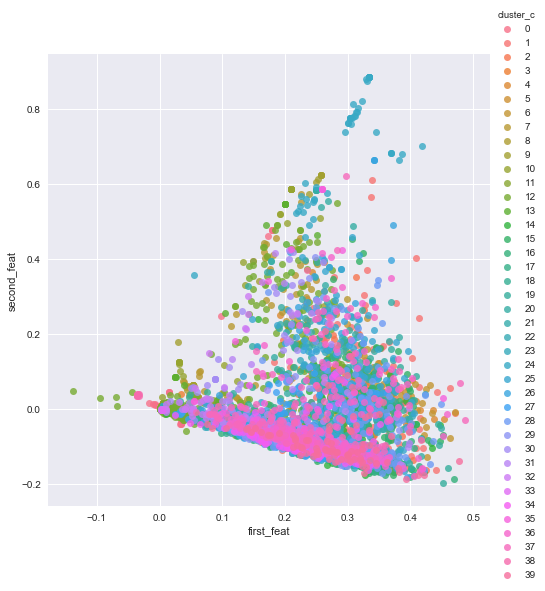

In [84]:
df = pd.DataFrame(lsa_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 7)

In [85]:
# get cluster centers
n_clusters = 40
clusters = [lsa_vecs[spec.labels_ == i] for i in range(n_clusters)]

master = []
for i in range(n_clusters):
    cent = list(np.mean(clusters[i], axis = 0))
    master.append(cent)
cluster_centers = np.reshape(master, (40, 300))

In [86]:
original_space_centroids = lsa.inverse_transform(cluster_centers)
order_centroids = original_space_centroids.argsort()[:, ::-1]

for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 ayesh
 justin
 yeah
 mor
 thi
 earnest
 commun
 mr
 cas
 tomorrow
 mat
 want
 thank
 fact
 gardin
 nic
 argu
 meet
 apprecy
 dav
 
 
Cluster 1: 
 think
 mr
 earnest
 thi
 presid
 dont
 wel
 hav
 ther
 ar
 som
 ind
 thing
 al
 peopl
 just
 say
 thos
 way
 said
 
 
Cluster 2: 
 wer
 ther
 going
 thi
 thos
 som
 hav
 mor
 report
 tim
 al
 mad
 presid
 peopl
 think
 mr
 decid
 concern
 said
 tak
 
 
Cluster 3: 
 kevin
 thank
 start
 stephany
 opportun
 want
 expery
 predict
 told
 washington
 behavy
 wont
 israel
 socy
 ent
 manufact
 er
 leg
 root
 nato
 
 
Cluster 4: 
 admin
 incom
 thi
 transit
 hav
 presid
 wel
 team
 policy
 obam
 wil
 presidentelect
 trump
 think
 strategy
 smoo
 pursu
 diff
 econom
 mr
 
 
Cluster 5: 
 ron
 dac
 frust
 debt
 presidentelect_donald_trump
 tweet
 pot
 margin
 fut
 underestim
 took
 begun
 scen
 beneficy
 shouldnt
 earlier_in
 dysfunct
 ess
 99th
 sabot
 
 
Cluster 6: 
 presid
 obam
 hav
 hes
 mr
 tim
 thi
 ther
 earnest
 think
 wel
 doe
 c

In [87]:
# does okay, buth others do better

** Gaussian mixture**

In [88]:
cluster_num = 40
gm = GaussianMixture(n_components = cluster_num)
gm.fit(lsa_vecs)

# predict one cluster per document
predicted_cluster = gm.predict(lsa_vecs)

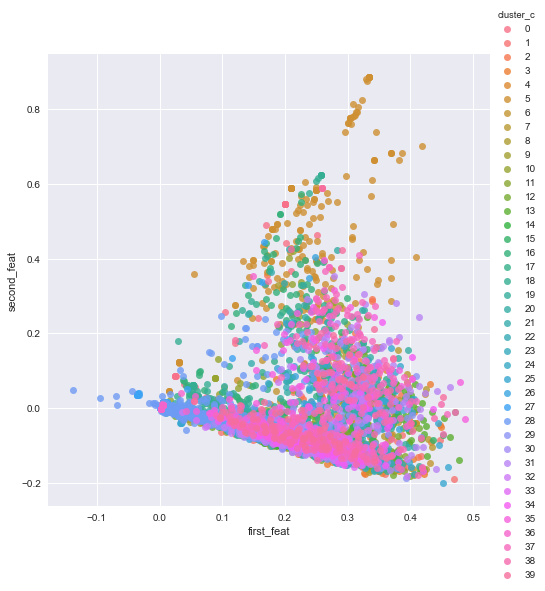

In [89]:
df = pd.DataFrame(lsa_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 7)

In [90]:
# get cluster centers
n_clusters = 40
clusters = [lsa_vecs[predicted_cluster == i] for i in range(n_clusters)]

master = []
for i in range(n_clusters):
    cent = list(np.mean(clusters[i], axis = 0))
    master.append(cent)
cluster_centers = np.reshape(master, (40, 300))

In [91]:
original_space_centroids = lsa.inverse_transform(cluster_centers)
order_centroids = original_space_centroids.argsort()[:, ::-1]

for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 ye
 mr
 earnest
 sir
 schultz
 anticip
 sign
 theyr
 wil
 exact
 hand
 confid
 lot
 il
 ar
 quick
 okay
 disput
 aft
 the_united_states
 
 
Cluster 1: 
 thos
 peopl
 ar
 hav
 thi
 country
 mak
 serv
 way
 presid
 al
 valu
 report
 becaus
 kind
 ev
 wer
 import
 ther
 lot
 
 
Cluster 2: 
 convers
 presidentelect
 hav
 presid
 mr
 cal
 earnest
 speak
 im
 team
 thos
 transit
 ther
 going
 thi
 som
 dont
 telephon
 priv
 know
 
 
Cluster 3: 
 democr
 republ
 congress
 presid
 thi
 hav
 ar
 ther
 work
 country
 think
 wil
 say
 forward
 som
 act
 mor
 just
 polit
 idea
 
 
Cluster 4: 
 campaign
 ayesh
 elect
 trump
 thi
 presid
 real
 presidentelect
 peopl
 trail
 wer
 al
 ther
 surpr
 think
 rhet
 wil
 dur
 diff
 mr
 
 
Cluster 5: 
 mr
 earnest
 okay
 yeah
 im
 wel
 margaret
 ther
 schultz
 sur
 wil
 ar
 point
 thi
 aw
 lalit
 rul
 good
 know
 post
 
 
Cluster 6: 
 admin
 thi
 doe
 sanct
 presid
 incom
 hav
 trump
 mor
 think
 said
 north_korea
 transit
 kind
 report
 feel
 n

In [92]:
# does okay but others do better

## LSI (gensim) + kmeans (3D plot)

In [93]:
corpus = matutils.Sparse2Corpus(vecs.transpose())
lsi = models.LsiModel(corpus, id2word=id2word, num_topics=300)
doc_vecs = lsi[corpus]
lsi_vecs = matutils.corpus2dense(doc_vecs, num_terms=300).transpose()
lsi_vecs = normalize(lsi_vecs)

In [94]:
cluster_num = 40
km = KMeans(n_clusters = cluster_num, random_state = 42)
km.fit(lsi_vecs)

# predict one cluster per document
predicted_cluster = km.predict(lsi_vecs)

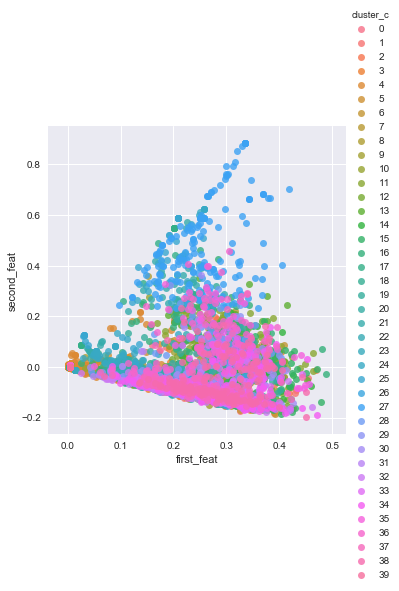

In [95]:
df = pd.DataFrame(lsi_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False)

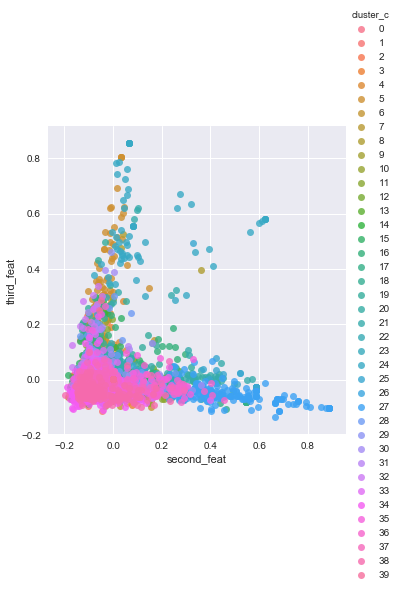

In [96]:
df = pd.DataFrame(lsi_vecs[:,1:3], columns = ['second_feat', 'third_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'second_feat', y='third_feat', hue = 'cluster_c', data = df, fit_reg = False)

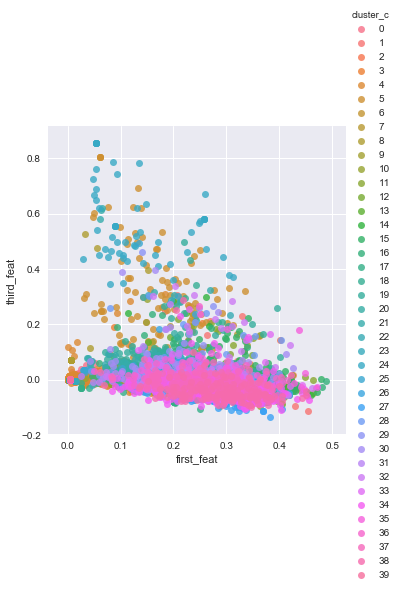

In [97]:
df = pd.DataFrame(lsi_vecs[:,0], columns = ['first_feat'])
df['third_feat'] = lsi_vecs[:,2]
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='third_feat', hue = 'cluster_c', data = df, fit_reg = False)

## NMF + kmeans

In [98]:
nmf = NMF(n_components=300)
nmf_vecs = nmf.fit_transform(vecs)
nmf_vecs = Normalizer(copy=False).fit_transform(nmf_vecs)

In [99]:
# note: this doesn't deal with the cluster, just gets the words from nmf...
# first pass at what words go with each component
nmf_df = pd.DataFrame(nmf.components_.round(5),columns = tfidf.get_feature_names())

for i in range(20):
    print('Cluster number: ' + str(i))
    print(nmf_df.iloc[i,:].sort_values(ascending = False)[:15])
    print("")

Cluster number: 0
presid                   1.99295
vic                      0.07777
obama                    0.03432
visit                    0.02419
bid                      0.02252
candid                   0.01950
spok                     0.01772
whil                     0.01566
ord                      0.01495
remark                   0.01333
counterpart              0.01226
rac                      0.01079
root                     0.00996
donald_trump_laughter    0.00634
travel                   0.00621
Name: 0, dtype: float64

Cluster number: 1
earnest                   2.58637
mr                        2.42144
list                      0.03056
alex                      0.01796
bret                      0.01725
saw                       0.01620
indee                     0.01562
earnest_happy_new_year    0.01480
earnest_ron               0.01480
huh                       0.01373
earnest_john              0.01231
richard                   0.01224
tricky                    0.01150
ch

In [100]:
cluster_num = 40
kmeans = KMeans(n_clusters=cluster_num)
km.fit(nmf_vecs)
predicted_cluster = km.predict(nmf_vecs)

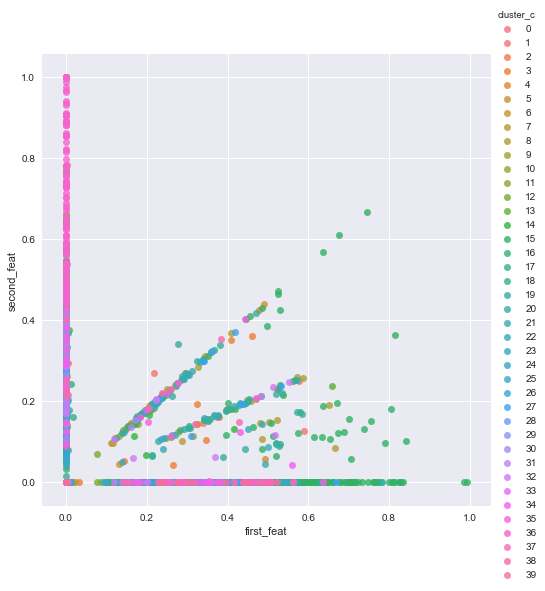

In [101]:
df = pd.DataFrame(nmf_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster

sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 7)

In [102]:
original_space_centroids = nmf.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [103]:
for i in range(cluster_num):
    print("Cluster %d:" % i, end='')
    print(" ")
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')  # print words in clusters
        print("")
    print(" ")
    print(" ")
print()

Cluster 0: 
 intellig
 commun
 bil
 poss
 think
 someth
 direct
 youv
 wev
 doesnt
 regard
 sur
 admin
 releas
 sign
 meet
 feel
 respons
 inform
 diff
 
 
Cluster 1: 
 aw
 im
 earnest
 mr
 spok
 presid
 hav
 theyv
 congress
 wil
 meet
 hap
 ask
 view
 rul
 plac
 endors
 schedule
 peopl
 theyr
 
 
Cluster 2: 
 transit
 smoo
 effect
 team
 ag
 admin
 ens
 presid
 commit
 hav
 ther
 ar
 thos
 mr
 presidentelect
 incom
 earnest
 going
 diff
 wer
 
 
Cluster 3: 
 hav
 isil
 thos
 wil
 going
 think
 ther
 al
 elect
 dont
 tak
 today
 mr
 peopl
 success
 opportun
 mak
 fight
 yo
 becaus
 
 
Cluster 4: 
 ye
 earnest
 mr
 sir
 anticip
 sorry
 youv
 sign
 mark
 person
 exact
 okay
 laught
 wil
 schultz
 cas
 certain
 disput
 yo
 day
 
 
Cluster 5: 
 respons
 sam
 presidentelect
 publ
 ther
 discuss
 the_united_states
 intellig
 proport
 hav
 presid
 commun
 think
 ar
 congress
 govern
 team
 sec
 wil
 oth
 
 
Cluster 6: 
 jord
 famy
 yo
 friday
 liv
 presid
 travel
 obvy
 thought
 mr
 earnest
 

## switch to count vectorizer for LDA

In [104]:
stemmed_ents = lancaster_stem(underscore_entities(test))

In [105]:
cv = CountVectorizer(stop_words = 'english')
vecs = cv.fit_transform(stemmed_ents)

In [106]:
cv_df = pd.DataFrame(vecs.todense(), columns=cv.get_feature_names())
cv_df.shape

(5000, 6295)

In [107]:
terms = cv.get_feature_names()

In [108]:
terms

['99',
 '9999',
 '9999_a',
 '9999_p',
 '99_99_million',
 '99__and',
 '99__fiscal_year_99',
 '99__im',
 '99__its',
 '99_a_year',
 '99_an_hour',
 '99_and_99',
 '99_billion',
 '99_days',
 '99_hours',
 '99_hours_ago',
 '99_in',
 '99_in_the_dow',
 '99_jobs',
 '99_million',
 '99_million_barrels',
 '99_minutes',
 '99_minutes_interview',
 '99_months',
 '99_or',
 '99_or_99',
 '99_or_99_years_ago',
 '99_or_so',
 '99_perc',
 '99_percent',
 '99_proisil',
 '99_special_operations_forces',
 '99_square_kilometers',
 '99_straight_months',
 '99_subpar_years',
 '99_to',
 '99_to_99',
 '99_trillion',
 '99_trillion_reduction',
 '99_world_series_victory',
 '99_years',
 '99_years_ago',
 '99_years_ago_this_week',
 '99_years_ago_today',
 '99_years_later',
 '99_years_or_so',
 '99character',
 '99day',
 '99foot',
 '99kilometer',
 '99month',
 '99nd',
 '99page',
 '99plus_million',
 '99pound',
 '99s',
 '99some_odd_years_or_so_ago',
 '99st',
 '99st_century',
 '99th',
 '_99',
 '_brady_briefing_room',
 '_bush',
 '_but',

## LDA (gensim) 

In [109]:
corpus = matutils.Sparse2Corpus(vecs.transpose())
lda = models.LdaModel(corpus=corpus, num_topics=40, id2word=id2word)
doc_vecs = lda[corpus]
lda_vecs = matutils.corpus2dense(doc_vecs, num_terms=300).transpose()
lda_vecs = normalize(lda_vecs)

In [110]:
# seems to repeat lots of common words
lda.print_topics(num_words = 50)

[(34,
  '0.038*"sanct" + 0.030*"ther" + 0.022*"ar" + 0.015*"som" + 0.015*"thi" + 0.015*"yo" + 0.013*"going" + 0.013*"talk" + 0.013*"job" + 0.012*"know" + 0.011*"fund" + 0.011*"work" + 0.011*"mor" + 0.010*"thes" + 0.010*"admin" + 0.009*"concern" + 0.009*"try" + 0.009*"kind" + 0.009*"hav" + 0.008*"export" + 0.007*"want" + 0.007*"wer" + 0.007*"thing" + 0.007*"declass" + 0.007*"area" + 0.007*"presid" + 0.006*"bas" + 0.006*"commanderinchief" + 0.006*"wil" + 0.006*"way" + 0.006*"ir" + 0.006*"decid" + 0.006*"wher" + 0.006*"lik" + 0.006*"continu" + 0.006*"cr" + 0.006*"said" + 0.005*"impos" + 0.005*"numb" + 0.005*"district" + 0.005*"ess" + 0.005*"act" + 0.005*"mak" + 0.005*"auth" + 0.005*"tak" + 0.005*"just" + 0.005*"annount" + 0.004*"report" + 0.004*"mind" + 0.004*"oth"'),
 (4,
  '0.019*"cyb" + 0.018*"mat" + 0.017*"ther" + 0.016*"thi" + 0.016*"say" + 0.015*"act" + 0.015*"intrud" + 0.013*"hav" + 0.013*"intellig" + 0.012*"mr" + 0.012*"word" + 0.012*"commun" + 0.012*"resourc" + 0.011*"wer" + 0.01

## LDA (sklearn)

In [111]:
lda = LatentDirichletAllocation(n_topics=40)
lda_vecs = lda.fit_transform(vecs)
lda_vecs = Normalizer(copy=False).fit_transform(lda_vecs)

/Users/braeburn/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [112]:
# note: gets top words from lda

lda_df = pd.DataFrame(lda.components_.round(5),columns = terms)

for i in range(20):
    print('Component number: ' + str(i))
    print(lda_df.iloc[i,:].sort_values(ascending = False)[:15])
    print("")

Component number: 0
a_few_days_ago       5.56987
april                5.45642
obsess               4.07483
domin                3.01314
percentil            2.98188
sud                  2.70065
japanes              2.43239
screening            2.41344
gossip               2.05776
kabil                2.02589
bloomberg            1.99652
philip               1.27260
appl                 1.21922
our_department_of    1.21917
the_past_year        1.21917
Name: 0, dtype: float64

Component number: 1
nic                   28.10536
caliph                13.62046
baghdad                6.30139
dav                    6.29788
kenne                  5.58096
bind                   3.76761
happy_new_year         3.69661
almost_eight_years     3.66465
suppress               3.55395
dimin                  3.29405
audiotap               3.16298
every_six_months       2.48412
gallon                 2.27752
tamperproof            2.27734
schultz_hans           2.24461
Name: 1, dtype: float64

Component 

**things to try**

dimensions  
100 (x)   
300 (x)  
500 (x)  

dimensionality reduction  
SVD (x)  
NMF (x)  
LDA (x)   
word2vec?  

cluster algorithms:
- kmeans (x)
- dbscan (x)
- hierarchical agglomerative clustering (x)  
- spectral (x)  

cluster numbers 
- 20 (x)
- 40 (x) 
- 60 (x) 
- 80 (x)

linkages
- ward / average (x)


In [113]:
break

SyntaxError: 'break' outside loop (<ipython-input-113-b20fcc2397e7>, line 1)

## misc.

### lsi on documents and words...this should be an alternate way to get words out of clusters but isn't working...

In [ ]:
# after having done tfidf...

# documents
corpus = matutils.Sparse2Corpus(vecs.transpose())
lsi = models.LsiModel(corpus, id2word=id2word, num_topics=300)
doc_vecs = lsi[corpus]
lsi_vecs = matutils.corpus2dense(doc_vecs, num_terms=300).transpose()

# words
vocabulary = list(tfidf.vocabulary_.keys())
vectorized_words = tfidf.transform(vocabulary)
word_corpus = matutils.Sparse2Corpus(vectorized_words.transpose())
word_vecs = lsi[word_corpus]
lsi_word_vecs = matutils.corpus2dense(word_vecs, num_terms = 300).transpose()

In [ ]:
lsi_vecs.shape

In [ ]:
lsi_word_vecs.shape

In [ ]:
# remove first dimension
lsi_vecs = lsi_vecs[:,1:]
lsi_word_vecs = lsi_word_vecs[:,1:]

# normalize
normalized_lsi_vecs = normalize(lsi_vecs)
normalized_word_vecs = normalize(lsi_word_vecs)

In [ ]:
km = KMeans(n_clusters = 20)
km.fit(normalized_lsi_vecs)
# predict one cluster per doc
predicted_cluster = km.predict(normalized_lsi_vecs)

In [ ]:
neigh = NearestNeighbors(algorithm = 'brute', metric = 'cosine')
neigh.fit(normalized_word_vecs)
words_nearest_center = neigh.kneighbors(km.cluster_centers_)[1]

In [ ]:
holder = []
for line in words_nearest_center:
    for num in line:
        holder.append(id2word[num])
nearest_words = np.asarray(holder)

pd.DataFrame(nearest_words.reshape([20, 5]))

In [ ]:
df = pd.DataFrame(lsi_vecs[:,0:2], columns = ['first_feat', 'second_feat'])
df['cluster_c'] = predicted_cluster
sns.lmplot(x = 'first_feat', y='second_feat', hue = 'cluster_c', data = df, fit_reg = False, size = 10)

In [ ]:
pd.Series(km.cluster_centers_[0]).sort_values(ascending=False)

In [ ]:
list(km.predict(lsi_word_vecs))